In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Saliency Map

### On-target epigenetic classification task

In [ ]:
saliency_map = np.load('saliency_values_class.npy')
saliency_map.shape # (100, 1, 23, 8)

#100: saliency map for 100 different data points.
#1: single chanel
#23: length of sequencedat
#8: number of features A, C, G, T , CTCF, Dnase, H3k4me3, RRBS

saliency_map_for_gene = saliency_map[:, :, :, :]  # Assuming single channel saliency map
print(saliency_map_for_gene.shape)

x = np.load('x_input_class.npy')
x_input = x[:, :, :, :]  # Assuming single channel saliency map
print(x_input.shape)

(100, 1, 23, 8)
(100, 8, 1, 23)


In [ ]:
print(x_input[0])

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.]]

 [[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


(8, 23)


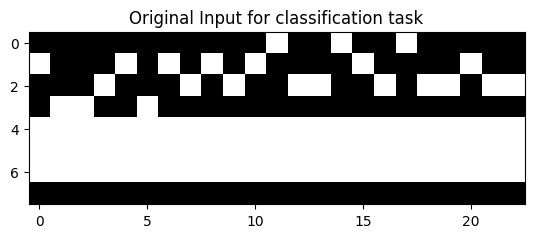

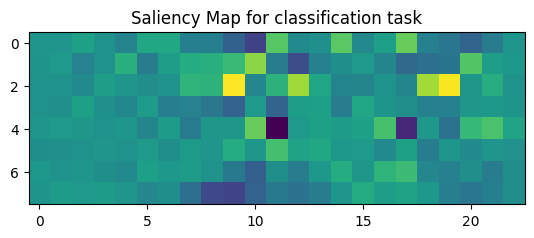

In [ ]:
sample_index = 0

original_input = np.squeeze(x_input[sample_index])
print(original_input.shape)
saliency_map = np.squeeze(saliency_map_for_gene[sample_index])
saliency_map = saliency_map.transpose()


# Plot the original input and its saliency map

plt.imshow(original_input, cmap='gray')
plt.title('Original Input for classification task')
plt.show()

plt.imshow(saliency_map)
plt.title('Saliency Map for classification task')
plt.show()

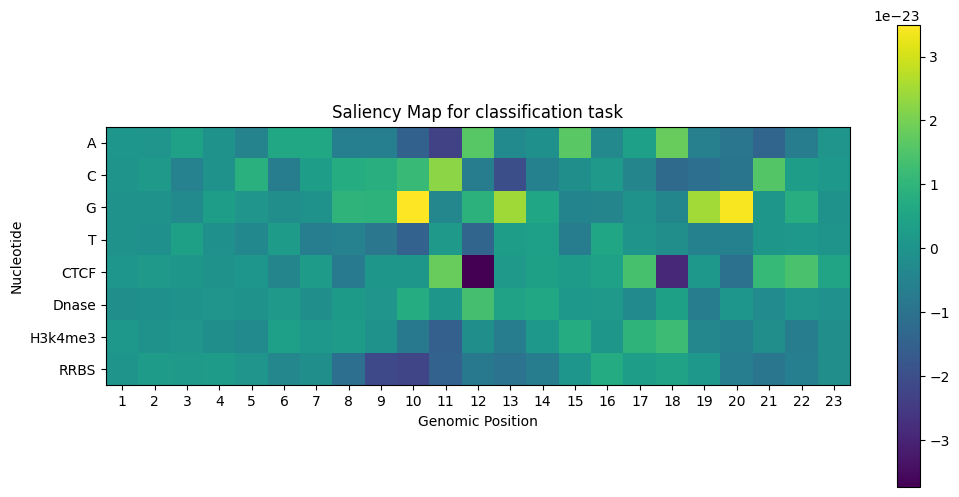

In [ ]:
heatmap = plt.get_cmap('viridis')(saliency_map)

# Display the original image, saliency map, and overlaid image
plt.figure(figsize=(12, 6))
plt.imshow(saliency_map, cmap='viridis')
plt.colorbar()

plt.title('Saliency Map for classification task')
y_ticks = np.arange(0, 8, 1)  # Custom tick locations
y_tick_labels = ['A', 'C', 'G', 'T', 'CTCF', 'Dnase', 'H3k4me3', 'RRBS']  # Custom tick labels

x_ticks = np.arange(0, 23, 1)  # Custom tick locations
x_tick_labels = np.arange(1, 24, 1)  # Custom tick labels

plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

plt.xlabel('Genomic Position')
plt.ylabel('Nucleotide')

plt.show()

### On-target Sequential Regression Task


In [ ]:
saliency_map = np.load('saliency_values_seq.npy')
print(saliency_map.shape)
#10: saliency map for 100 different data points.
#1: single chanel
#23: length of sequencedat
#4: number of features A, C, G, T , CTCF, Dnase, H3k4me3, RRBS

x = np.load('x_input_seq.npy')
x_input = x[:, :4, :, :]  # Assuming single channel saliency map
print(x_input.shape)

(10, 1, 23, 4)
(10, 4, 1, 23)


(4, 23)


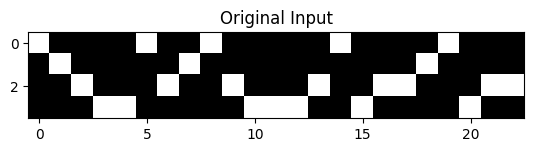

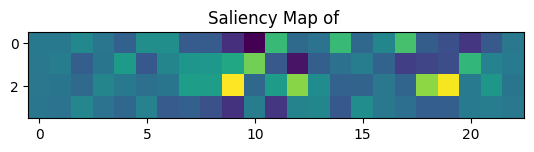

In [ ]:
sample_index = 0

original_input = np.squeeze(x_input[sample_index])
print(original_input.shape)
saliency_map = np.squeeze(saliency_map_for_gene[sample_index])
saliency_map = saliency_map.transpose()


# Plot the original input and its saliency map

plt.imshow(original_input, cmap='gray')  # Assuming grayscale input
plt.title('Original Input')
plt.show()

plt.imshow(saliency_map)  # Assuming grayscale input
plt.title('Saliency Map of ')
plt.show()

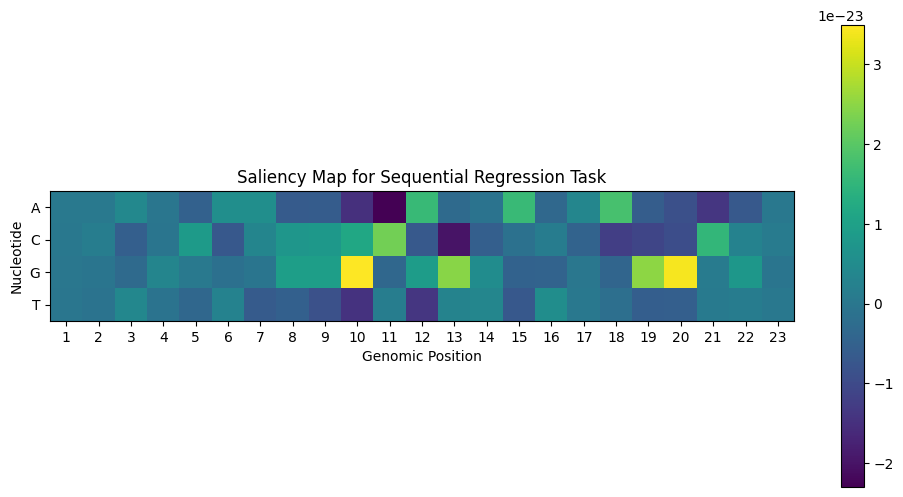

In [ ]:
heatmap = plt.get_cmap('viridis')(saliency_map)

# Display the original image, saliency map, and overlaid image
plt.figure(figsize=(12, 6))
plt.imshow(saliency_map, cmap='viridis')
plt.colorbar()

plt.title('Saliency Map for Sequential Regression Task')
y_ticks = np.arange(0, 4, 1)  # Custom tick locations
y_tick_labels = ['A', 'C', 'G', 'T']  # Custom tick labels

x_ticks = np.arange(0, 23, 1)  # Custom tick locations
x_tick_labels = np.arange(1, 24, 1)  # Custom tick labels

plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

plt.xlabel('Genomic Position')
plt.ylabel('Nucleotide')

plt.show()

### On-target epigenetic regression task

In [ ]:
saliency_map = np.load('saliency_values_reg.npy')
saliency_map.shape # (100, 1, 23 ,8)
#100: saliency map for 100 different data points.
#1: single chanel
#23: length of sequencedat
#8: number of features A, C, G, T , CTCF, Dnase, H3k4me3, RRBS

saliency_map_for_gene = saliency_map[:, :, :, :4]  # Assuming single channel saliency map
print(saliency_map_for_gene.shape)

x = np.load('x_input_reg.npy')
x_input = x[:, :4, :, :]  # Assuming single channel saliency map
print(x_input.shape)

(100, 1, 23, 4)
(100, 4, 1, 23)


(4, 23)


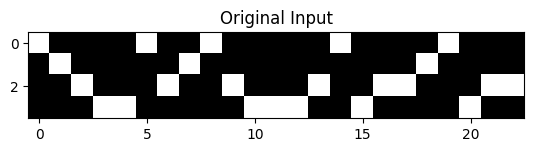

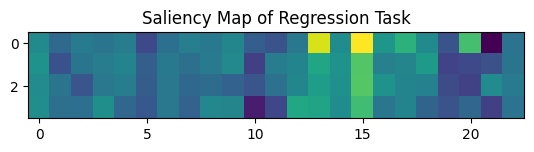

In [ ]:
sample_index = 0

original_input = np.squeeze(x_input[sample_index])
print(original_input.shape)
saliency_map = np.squeeze(saliency_map_for_gene[sample_index])
saliency_map = saliency_map.transpose()


# Plot the original input and its saliency map

plt.imshow(original_input, cmap='gray')
plt.title('Original Input')
plt.show()

plt.imshow(saliency_map)
plt.title('Saliency Map of Regression Task')
plt.show()

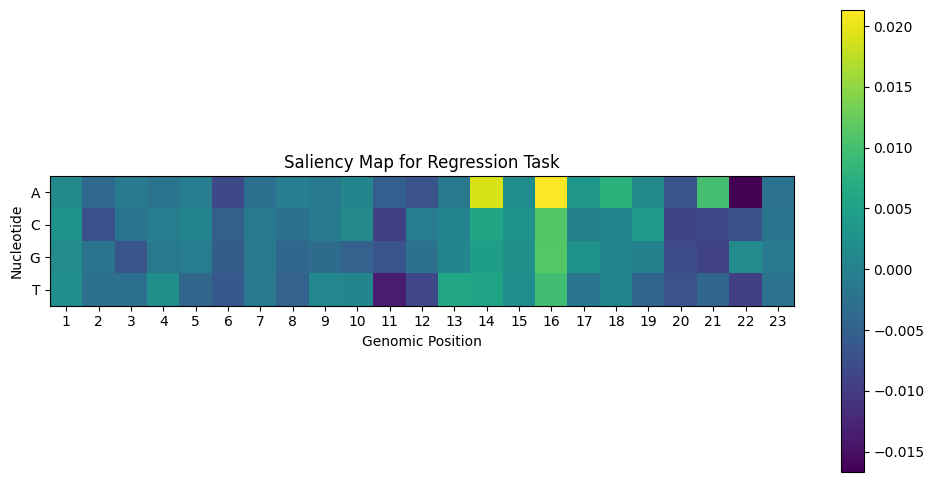

In [ ]:
heatmap = plt.get_cmap('viridis')(saliency_map)

# Display the original image, saliency map, and overlaid image
plt.figure(figsize=(12, 6))
plt.imshow(saliency_map, cmap='viridis')
plt.colorbar()

plt.title('Saliency Map for Regression Task')
y_ticks = np.arange(0, 4, 1)  # Custom tick locations
y_tick_labels = ['A', 'C', 'G', 'T']  # Custom tick labels

x_ticks = np.arange(0, 23, 1)  # Custom tick locations
x_tick_labels = np.arange(1, 24, 1)  # Custom tick labels

plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

plt.xlabel('Genomic Position')
plt.ylabel('Nucleotide')

plt.show()

In [3]:
import pandas as pd

def grna_preprocess(lines):
    length = 23
    data_n = len(lines)
    seq = np.zeros((data_n, length, 4), dtype=int)
    for l in range(data_n):
        data = lines[l]
        seq_temp = data
        for i in range(length):
            if seq_temp[i] in "Aa":
                seq[l, i, 0] = 1
            elif seq_temp[i] in "Cc":
                seq[l, i, 1] = 1
            elif seq_temp[i] in "Gg":
                seq[l, i, 2] = 1
            elif seq_temp[i] in "Tt":
                seq[l, i, 3] = 1
    return seq


def epi_preprocess(lines):
    length = 23
    data_n = len(lines)
    epi = np.zeros((data_n, length), dtype=int)
    for l in range(data_n):
        data = lines[l]
        epi_temp = data
        for i in range(length):
            if epi_temp[i] in "A":
                epi[l, i] = 1
            elif epi_temp[i] in "N":
                epi[l, i] = 0
    return epi


def preprocess(file_path, usecols):
    data = pd.read_csv(file_path, usecols=usecols)
    data = np.array(data)
    ctcf, dnase, h3k4me3, rrbs = epi_preprocess(data[:, 0]), epi_preprocess(data[:, 1]), epi_preprocess(data[:, 2]), epi_preprocess(data[:, 3])
    epi = []
    for i in range(len(data)):
        ctcf_t, dnase_t, h3k4me3_t, rrbs_t = pd.DataFrame(ctcf[i]), pd.DataFrame(dnase[i]), pd.DataFrame(h3k4me3[i]), pd.DataFrame(rrbs[i])
        epi_t = pd.concat([ctcf_t, dnase_t, h3k4me3_t, rrbs_t], axis=1)
        epi_t = np.array(epi_t)
        epi.append(epi_t)
    epi = np.array(epi)
    return epi


def load_data(train_file):
    train_data = pd.read_csv(train_file, usecols=[4, 9])
    train_data = np.array(train_data)
    train_seq, train_y = train_data[:, 0], train_data[:, 1]
    train_seq = grna_preprocess(train_seq)
    train_epi = preprocess(train_file, [5, 6, 7, 8])
    train_y = train_y.reshape(len(train_y), -1)

    return train_seq, train_epi, train_y




In [18]:
train_seq, train_epi, train_y = load_data("max_min_data.csv")
seq_expand = train_seq.reshape((2, 4, 1, 23))
epi_expand = train_seq.reshape((2, 4, 1, 23))
merged_array = np.concatenate((seq_expand, epi_expand), axis=1)
print(merged_array)
print(train_y)
np.save("merged_array.npy", merged_array)

[[[[0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0]]

  [[0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1]]

  [[0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]]

  [[1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0]]

  [[0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0]]

  [[0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1]]

  [[0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]]

  [[1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0]]]


 [[[0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0]]

  [[0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1]]

  [[0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0]]

  [[0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0]]

  [[0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0]]

  [[0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1]]

  [[0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0]]

  [[0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0]]]]
[[0.88665013]
 [0.002470402]]
